In [1]:
from netCDF4 import Dataset
import netCDF4
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.basemap import Basemap # Import the Basemap toolkit
import numpy as np # Import the Numpy package
from datetime import datetime
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
import matplotlib.gridspec as gridspec
import matplotlib.mlab as mlab
import matplotlib.cm as colors
from glob import glob
# from geopy.geocoders import Nominatim
import pandas as pd
import matplotlib.dates as mdates
import seaborn as sns
from matplotlib.dates import  DateFormatter

/home/mpim/m300382/.conda/envs/my_env/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [2]:
diri='/scratch/local1/m300382/gens/grib/'
diri_images='/scratch/local1/m300382/gens/'
cities = ["Hamburg"]


n_pert=[]

first = True 
for fname in glob(diri+"*.nc"):
    nc=Dataset(fname)
    if first == True:
        # Initialize the variables to be filled
        dims = np.shape(nc.variables['tp'])  # (64, 361, 720)
        t_2m=np.empty(shape=(0,dims[0],dims[1],dims[2]), dtype='float32')
        t_850hpa=np.empty(shape=(0,dims[0],dims[1],dims[2]), dtype='float32')
        tot_prec=np.empty(shape=(0,dims[0],dims[1],dims[2]), dtype='float32')
        snow=np.empty(shape=(0,dims[0],dims[1],dims[2]), dtype='float32')
        wind_speed_10m=np.empty(shape=(0,dims[0],dims[1],dims[2]), dtype='float32')
    time_var = nc.variables['time']

    first=False
    
    # Use only files with the same time dimension. Note that this not exactly true as it assumes
    # that the dimesions read from the first file are correct.
    # At least this won't produce an error in case a file has different time steps.
    if len(nc.dimensions['time']) == dims[0]:
        t_2m=np.append(t_2m, [nc.variables['2t'][:,0,:,:]-273.15], axis=0)
        t_850hpa=np.append(t_850hpa, [nc.variables['t'][:,0,:,:]-273.15], axis=0)
        tot_prec=np.append(tot_prec, [nc.variables['tp'][:]], axis=0)
        snow=np.append(snow, [nc.variables['csnow'][:]], axis=0)
        wind_speed_10m=np.append(wind_speed_10m, [(nc.variables['10u'][:,0,:,:]**2+nc.variables['10v'][:,0,:,:]**2)**(0.5)], axis=0)

        if (fname[fname.find(".nc")-2:fname.find(".nc")]) =="00": #this is the control run
            n_pert.append(0)
        else:
            n_pert.append(nc.variables['2t'].realization)
    

n_pert=np.array(n_pert)

wind_speed_10m=3.6*wind_speed_10m
lon=np.where(nc.variables['lon'][:] >=180,nc.variables['lon'][:]-360, nc.variables['lon'][:] )
lat=nc.variables['lat'][:]
dtime = netCDF4.num2date(time_var[:],time_var.units)

In [3]:
from geopy.geocoders import Nominatim

t_2m_point={}
t_850hpa_point={}
tot_prec_point={}
snow_point={}
wind_speed_10m_point={}
geolocator = Nominatim()
for city in cities:
    loc = geolocator.geocode(city)
    ilat=np.argmin(abs(lat-loc.latitude))
    ilon=np.argmin(abs(lon-loc.longitude))

    t_2m_point[city] = t_2m[:,:,ilat,ilon]
    t_850hpa_point[city] = t_850hpa[:,:,ilat,ilon]
    tot_prec_point[city] = tot_prec[:,:,ilat,ilon]
    snow_point[city] = snow[:,:,ilat,ilon]
    wind_speed_10m_point[city] = wind_speed_10m[:,:,ilat,ilon]

/home/mpim/m300382/.conda/envs/my_env/lib/python2.7/site-packages/geopy/geocoders/osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


In [40]:
sns.set(style="white")
#city_to_plot="Roma"
var_to_plot=t_850hpa_point
var2_to_plot=tot_prec_point

for (city_to_plot,latitude,longitude) in cities:
    fig = plt.figure(1, figsize=(9,6))
    plt.plot_date(dtime,var_to_plot[city_to_plot].T,'-',lw=1)
    plt.plot_date(dtime,var_to_plot[city_to_plot].T[:,np.where(n_pert==0)[0]],'-',lw=2.5,color='black')
    plt.ylabel("850 hPa temperature [C]")
    plt.ylim(-25, 20)
    
    plt.gca().minorticks_on()
    plt.gca().grid(which='major', linestyle='-', linewidth='0.5', color='black')
    plt.gca().grid(which='minor', linestyle=':', linewidth='0.3', color='black')
    
    ax2 = plt.gca().twinx()
    ax2.plot_date(dtime,var2_to_plot[city_to_plot].T,'--',lw=1.5)
    ax2.set_ylabel("Precipitation [mm]")
    ax2.set_ylim(0, 50)
    
    plt.title("GEFS forecast for "+city_to_plot+" | Run "+dtime[0].strftime("%Y%m%d %H"))
    fig.autofmt_xdate()
    
    plt.savefig("spaghetti_"+city_to_plot, dpi=150, bbox_inches='tight')
    plt.clf()

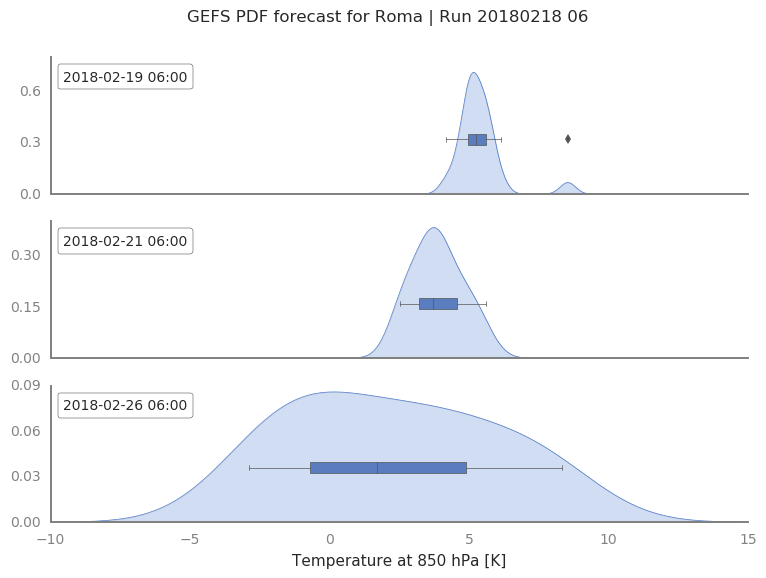

In [377]:
city_to_plot="Roma"
var_to_plot=t_2m_point
myDates= ["2018-02-19 06:00", "2018-02-21 06:00", "2018-02-26 06:00"]

dates = pd.to_datetime(dtime)
df = pd.DataFrame(data=var_to_plot[city_to_plot].T)
df['date']=dates
df = df.set_index(['date'])
df_subset=df.loc[pd.to_datetime(myDates)]

fig = plt.figure(1, figsize=(9, 6))

nrows=np.shape(myDates)[0]
rows=np.arange(start=0, stop=nrows, step=1)
gridspec.GridSpec(nrows,1)

sns.set(style="white", palette="muted", color_codes=True)
sns.set_context(rc={"lines.linewidth": 0.5})
plt.rc_context({'axes.edgecolor':'grey', 'xtick.color':'grey', 'ytick.color':'grey'})
plt.suptitle("GEFS PDF forecast for "+city_to_plot+" | Run "+dtime[0].strftime("%Y%m%d %H"))

for row in rows:
    if row == rows[0]:
        ax1=plt.subplot2grid((nrows,1), (row,0))
    else: 
        plt.subplot2grid((nrows,1), (row,0),sharex=ax1)
    ax2=sns.distplot(df.loc[myDates[row]],hist=False,kde_kws={"shade":True})
    ax3 = ax2.twinx()
    ax3.get_xaxis().set_visible(False)
    sns.boxplot(x=df.loc[myDates[row]],ax=ax3)
    sns.despine()
    ax3.set(ylim=(-4, 6))
    at = AnchoredText(myDates[row], prop=dict(size=10), frameon=True,loc=2)
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    plt.gca().add_artist(at)
    ax2.yaxis.set_major_locator(plt.MaxNLocator(3))
    if row != rows[-1]:
        ax2.get_xaxis().set_visible(False)
    else: 
        ax2.get_xaxis().set_visible(True)
        ax2.set_xlabel('Temperature at 850 hPa [C]')

In [7]:
time=pd.to_datetime(dtime)
pos = np.array((time-time[0]) / pd.Timedelta('1 hour')).astype("int")

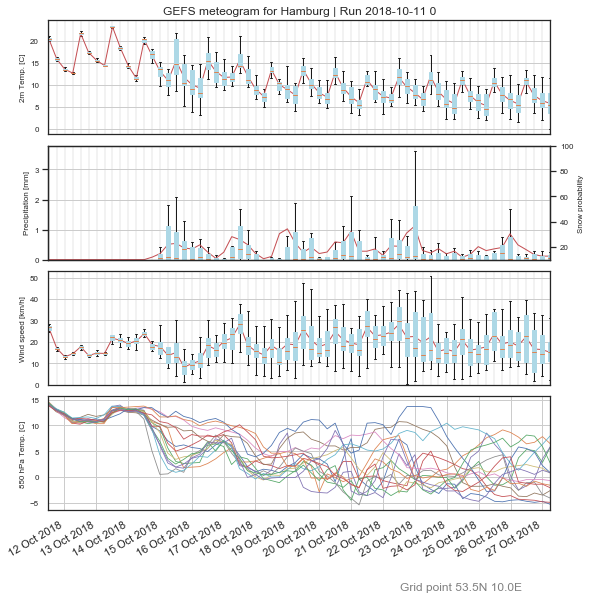

<Figure size 432x288 with 0 Axes>

In [23]:
nrows=4
ncols=1
sns.set(style="white")

for city_to_plot in cities:
    loc = geolocator.geocode(city_to_plot)
    ilat=np.argmin(abs(lat-loc.latitude))
    ilon=np.argmin(abs(lon-loc.longitude))
    
    time=pd.to_datetime(dtime)
    pos = np.array((time-time[0]) / pd.Timedelta('1 hour')).astype("int")

    fig = plt.figure(1, figsize=(9,10))
    ax1=plt.subplot2grid((nrows,ncols), (0,0))
    ax1.set_title("GEFS meteogram for "+city_to_plot+" | Run "+time_var.units[12:24])
    
    bplot=ax1.boxplot(t_2m_point[city_to_plot], patch_artist=True,
                      showfliers=False, positions=pos, widths=3)
    for box in bplot['boxes']:
        box.set(color='LightBlue')
        box.set(facecolor='LightBlue')

    ax1.plot(pos, np.mean(t_2m_point[city_to_plot], axis=0), 'r-', linewidth=1)
    ax1.set_ylabel("2m Temp. [C]",fontsize=8)
    ax1.yaxis.grid(True)
    ax1.xaxis.grid(True, color='gray', linewidth=0.2)
    ax1.tick_params(axis='y', which='major', labelsize=8)
    ax1.tick_params(axis='x', which='both', bottom=False)

    ax2=plt.subplot2grid((nrows,ncols), (1,0))
    bplot_rain=ax2.boxplot(tot_prec_point[city_to_plot], patch_artist=True,
                      showfliers=False, positions=pos, widths=3)
    for box in bplot_rain['boxes']:
        box.set(color='LightBlue')
        box.set(facecolor='LightBlue')
        
    ax2.plot(pos, np.mean(tot_prec_point[city_to_plot], axis=0), 'r-', linewidth=1)
    ax2.set_ylim(bottom=0)
    ax2b = ax2.twinx()
    ax2b.plot(pos, np.mean(snow_point[city_to_plot]*100, axis=0), '*',color='purple')
    ax2b.set_ylabel("Snow probability",fontsize=8)
    ax2b.set_ylim(10, 100)
    ax2.yaxis.grid(True)
    ax2.set_ylabel("Precipitation [mm]",fontsize=8)
    ax2.xaxis.grid(True, color='gray', linewidth=0.2)
    ax2.tick_params(axis='y', which='major', labelsize=8)
    ax2b.tick_params(axis='y', which='major', labelsize=8)

    ax3=plt.subplot2grid((nrows,ncols), (2,0))
    bplot_wind=ax3.boxplot(wind_speed_10m_point[city_to_plot], patch_artist=True,
                      showfliers=False, positions=pos, widths=3)
    for box in bplot_wind['boxes']:
        box.set(color='LightBlue')
        box.set(facecolor='LightBlue')
    ax3.plot(pos, np.mean(wind_speed_10m_point[city_to_plot], axis=0), 'r-', linewidth=1)

    ax3.yaxis.grid(True)
    ax3.set_ylabel("Wind speed [km/h]",fontsize=8)
    ax3.tick_params(axis='y', which='major', labelsize=8)
    ax3.set_ylim(bottom=0)
    ax3.xaxis.grid(True, color='gray', linewidth=0.2)

    ax4=plt.subplot2grid((nrows,ncols), (3,0))
    ax4.plot_date(time, t_850hpa_point[city_to_plot][:,:].T, '-',linewidth=0.8)
    ax4.set_xlim(dtime[0],dtime[-1])
    ax4.set_ylabel("850 hPa Temp. [C]",fontsize=8)
    ax4.tick_params(axis='y', which='major', labelsize=8)
    ax4.yaxis.grid(True)
    ax4.xaxis.grid(True)
    ax4.xaxis.set_major_locator(mdates.DayLocator())
    ax4.xaxis.set_major_formatter(DateFormatter('%d %b %Y'))

    ax4.annotate('Grid point %3.1fN %3.1fE' % (lat[ilat], lon[ilon]), xy=(0.7, -0.7), xycoords='axes fraction', color="gray")

    fig.subplots_adjust(hspace=0.1)
    fig.autofmt_xdate()
#     plt.savefig(diri_images+"meteogram_"+city_to_plot, dpi=150, bbox_inches='tight')
    plt.show()
    plt.clf()